In [10]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
#from brainstat.stats.SLM import SLM
#from brainstat.stats.terms import FixedEffect
#from brainstat.datasets.base import combine_surfaces
import seaborn as sns
from brainspace.datasets import load_mask

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_10k != 0

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)


# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, Smooth=False, kernel=None):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=0.9)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        if Smooth==True:
            grad[i] = smooth_surf(inf_lh, inf_rh, g_nan, mask_surf,Niter=3, Relax=0.35, Kernel='uniform')
        else:
            grad[i] = g_nan
    
    return(MPCgm, grad)

def map_to_labels5k(mpc_sliced, mask):
    # Get the index of the non medial wall regions
    mask_indx = np.where(mask==1)[0]
    # map to the labels
    labels_5k = np.full(mask.shape, np.nan)
    labels_5k[mask_indx] = mpc_sliced
    return(labels_5k)

    
# Load files
def make_mpc5k(files):
    # Load all the matrices
    Ndim=9684
    M=np.empty([Ndim, Ndim, len(files)], dtype=float)
    for i, f in enumerate(files):
        print(f)
        int_profile = nb.load(f).darrays[0].data
        M[:,:,i] = build_mpc(smooth_intensities(int_profile), mask_surf)

    return M

In [11]:
def inflate_surf(orig_lh, orig_rh, ref_lh, ref_rh, W=0.15):
    """
    This functions inflates a surface a determined amount [W{0:1}] to a reference
    
    Parameters
    ----------
        orig_lh : vtkPolyData or VTKObjectWrapper
                    left input original surface
        orig_rh : vtkPolyData or VTKObjectWrapper
                    right input original surface
        ref_lh  : vtkPolyData or VTKObjectWrapper
                    left input reference surface
        ref_rh  : vtkPolyData or VTKObjectWrapper
                    right input reference surface
        W       : float value from 0 to 1
        
    Returns
    -------
        new_lh : vtkPolyData or VTKObjectWrapper
                    left output inflated surface
        new_rh : vtkPolyData or VTKObjectWrapper
                    right output inflated surface
        
    """
    def inflate(orig, ref, Winf):
        # Convert BSPolyData objects to numpy arrays
        inf_coord = copy.copy(orig.points)
        inf_triag = copy.copy(orig.GetCells2D())
        
        # Inflated mean surface
        maxs = np.max(orig.points, axis=0)
        mins = np.min(orig.points, axis=0)
        maxsp = np.max(ref.points, axis=0)
        minsp = np.min(ref.points, axis=0)
        
        for i in range(3):
            inf_coord[:,i] = (((ref.points[:, i] - minsp[i]) / (maxsp[i] - minsp[i]))
                                 * (maxs[i] - mins[i]) + mins[i]) * Winf + orig.points[:, i] * (1 - Winf)
        
        # Create the new surface
        new_surf = build_polydata(inf_coord, cells=inf_triag)
        
        return(new_surf)
    
    new_lh = inflate(orig_lh, ref_lh, Winf=W)
    new_rh = inflate(orig_rh, ref_rh, Winf=W)
    
    return(new_lh, new_rh)

# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)

In [12]:
# Set dataset PNI as working directory
os.chdir('/data/mica3/BIDS_PNI/data_release/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Load spheres fsLR5k
sphere_lh = read_surface(micapipe+'/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
sphere_rh = read_surface(micapipe+'/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')

# load stuff
mask_32k = load_mask(join=True)

# Labels and boolean mask
mask_surf = mask_5k != 0

# Inflated fsLR-5k surfaces
inf5_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf5_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

In [31]:
def load_qmri_intensity(qmri='', verbose=False):

    # Extract subject and session information from each row
    files = []
    file_path = f"sub-*/ses-*/mpc/acq-{qmri}2/*_surf-fsLR-5k_desc-MPC.shape.gii"
    files.extend(glob.glob(file_path))
    
    # Print the file paths
    if verbose == True:
        print("Files used:")
        for file_path in files:
            print(file_path)

    # Load intensity profiles from each file
    profiles = []
    for file_path in files:
        profile_data = nb.load(file_path).darrays[0].data
        # Smooth each intensity
        profile_data_i = smooth_intensities(profile_data)
        # Replace values in midwall with NaN where mask_10k is False
        profile_data_i[:, mask_5k == False] = np.nan
        #profile_data_i = profile_data_i[1:]
        profiles.append(profile_data_i)
    
    profiles = np.array(profiles)

    # Extract subject and session information
    subjects = set()
    for file_path in files:
        parts = file_path.split('/')
        subject = parts[0][4:]  # Extract subject ID from the directory name
        subjects.add(subject)

    print(f"Intensity Profiles of {qmri} maps - Number of subjects: {len(subjects)}")

    return profiles

In [18]:
MTSAT = load_qmri_intensity('MTSAT')

Intensity Profiles of MTSAT maps - Number of subjects: 10


In [19]:
mean_MTSAT = np.mean(MTSAT, axis=0)

In [26]:
import os
import glob
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_5k != 0

# Environment variables
surf='fsLR-5k'
out_maps='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/noFA_SWM'
out_surf='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/I_figured_out_SWM/rawdata/micapipe_v0.2.0/sub-MNI152/surf'

# Load MNI white matter surface
MNI_wmL = read_surface(f'{out_surf}/sub-MNI152_hemi-L_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')
MNI_wmR = read_surface(f'{out_surf}/sub-MNI152_hemi-R_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')

# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, kernel=None, sparsity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparsity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return(MPCgm, grad)

In [27]:
MPC = build_mpc(mean_MTSAT, mask_surf) # compute mMPC

/tmp/ipykernel_49270/7982335.py:53: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


In [29]:
# Calculate the gradients
Ngrad=5
MPC_all, grad = mpc_dm(MPC, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

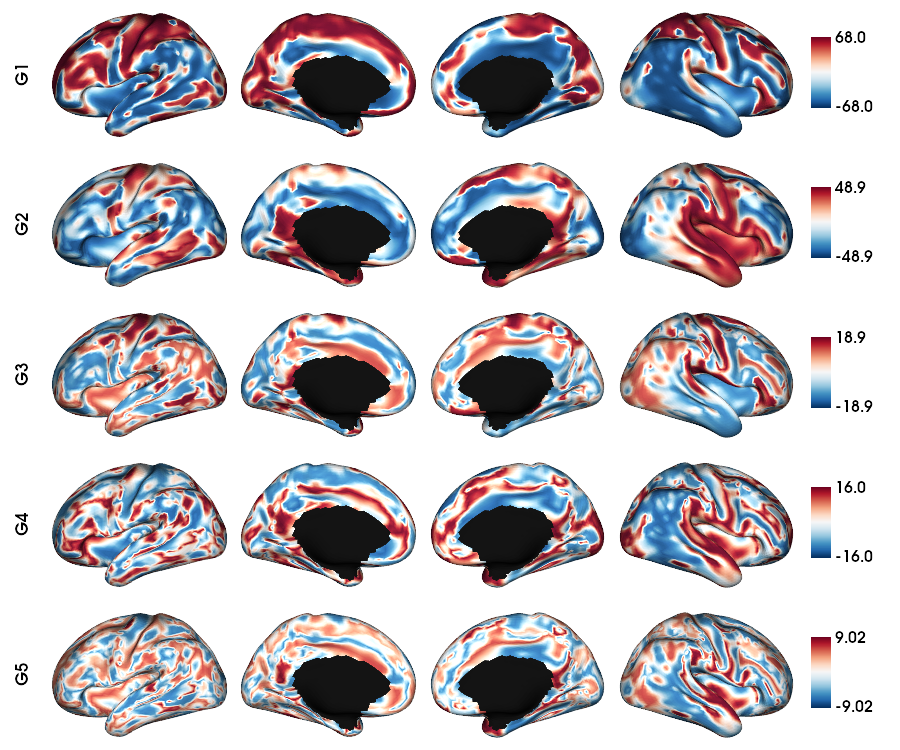

In [30]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True, color_range = 'sym',
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [32]:
MPC_MTSAT = load_qmri_intensity('MTSAT')

Intensity Profiles of MTSAT maps - Number of subjects: 10


In [33]:
mean_MPC_MTSAT = np.mean(MPC_MTSAT, axis=0)

In [34]:
mean_MPC_MTSAT.shape

(9684, 9684)

In [35]:
# Calculate the gradients
Ngrad=5
MPC_all, grad = mpc_dm(mean_MPC_MTSAT, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


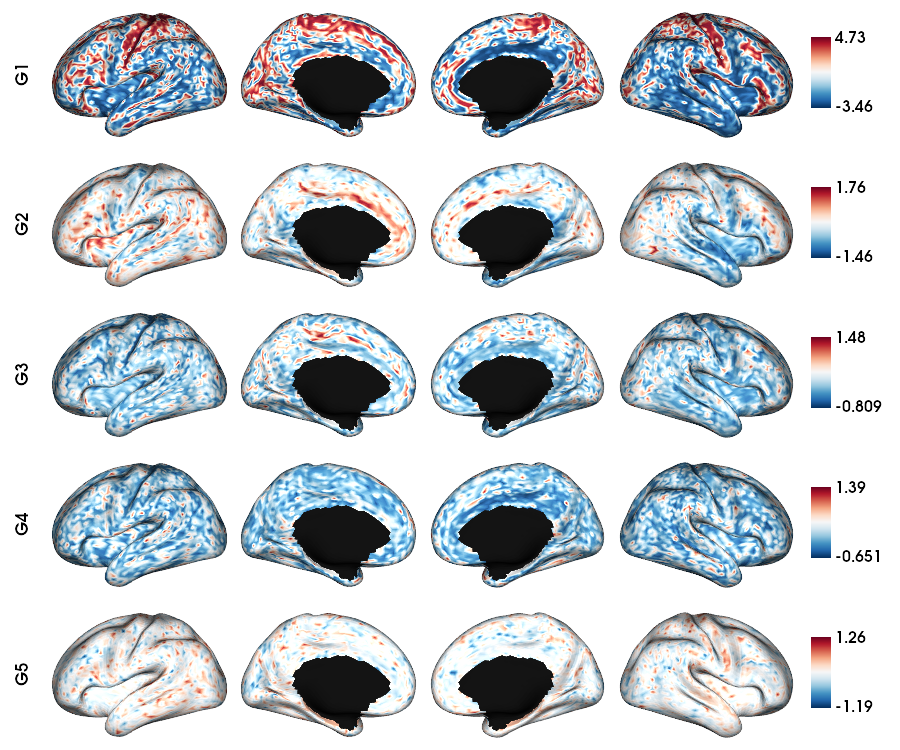

In [37]:
# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)